## Lab: Visitor Analytics with AWS Rekognition, S3, and Glue


### Setup

In [ ]:
import boto3
import os
from dotenv import load_dotenv

s3_client = boto3.client('s3')
load_dotenv(../.env)

True

In [6]:
# List of car makes to search for (already uppercase)
car_makes = [
    'TOYOTA', 'HONDA', 'FORD', 'CHEVROLET', 'NISSAN', 'JEEP', 'HYUNDAI', 'KIA',
    'SUBARU', 'RAM', 'GMC', 'BMW', 'MERCEDES-BENZ', 'LEXUS', 'AUDI', 'VOLKSWAGEN',
    'TESLA', 'ACURA', 'CADILLAC', 'CHRYSLER', 'DODGE', 'INFINITI', 'LINCOLN', 'MAZDA'
]

# List of full US state names for searching
us_state_names = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
    'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
    'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
    'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina',
    'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
    'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'District of Columbia'
]

### Upload raw images from local directory to S3

In [7]:
directory = 'Images'
bucket_name = 'techcatalyst-raw'
path_prefix = 'fabiola/ai/images_raw/'

for filename in os.listdir(directory):
    if filename.lower().endswith('.jpg'):
        file_path = os.path.join(directory, filename)
        s3_key = f"{path_prefix}{filename}"

        s3_client.upload_file(Filename=file_path, Bucket=bucket_name, Key=s3_key)
        print(f"Uploaded {filename} to s3://{bucket_name}/{s3_key}")

        

Uploaded 1c62dcbf9a6c22c7.jpg to s3://techcatalyst-raw/fabiola/ai/images_raw/1c62dcbf9a6c22c7.jpg
Uploaded b541cf545aaca2c4.jpg to s3://techcatalyst-raw/fabiola/ai/images_raw/b541cf545aaca2c4.jpg
Uploaded f3ecacf903a52827.jpg to s3://techcatalyst-raw/fabiola/ai/images_raw/f3ecacf903a52827.jpg
Uploaded 2f6fbf1e163dd7ed.jpg to s3://techcatalyst-raw/fabiola/ai/images_raw/2f6fbf1e163dd7ed.jpg
Uploaded f484d1b789e6ed63.jpg to s3://techcatalyst-raw/fabiola/ai/images_raw/f484d1b789e6ed63.jpg
Uploaded 27801b00dbefaa6d.jpg to s3://techcatalyst-raw/fabiola/ai/images_raw/27801b00dbefaa6d.jpg
Uploaded bd308fea65994fd5.jpg to s3://techcatalyst-raw/fabiola/ai/images_raw/bd308fea65994fd5.jpg
Uploaded 2c75228218b9f9c5.jpg to s3://techcatalyst-raw/fabiola/ai/images_raw/2c75228218b9f9c5.jpg
Uploaded 3831e7027912e1e2.jpg to s3://techcatalyst-raw/fabiola/ai/images_raw/3831e7027912e1e2.jpg
Uploaded 30e5cfb58d3535e5.jpg to s3://techcatalyst-raw/fabiola/ai/images_raw/30e5cfb58d3535e5.jpg
Uploaded 2c57bd6d734

### Object list

In [9]:
import awswrangler as wr

objects = wr.s3.list_objects('s3://techcatalyst-raw/fabiola/ai/images_raw/')
objects[0:5]


['s3://techcatalyst-raw/fabiola/ai/images_raw/19306e847f2dbe79.jpg',
 's3://techcatalyst-raw/fabiola/ai/images_raw/1ac5b485b95c9f00.jpg',
 's3://techcatalyst-raw/fabiola/ai/images_raw/1c00790f8e592ab2.jpg',
 's3://techcatalyst-raw/fabiola/ai/images_raw/1c62dcbf9a6c22c7.jpg',
 's3://techcatalyst-raw/fabiola/ai/images_raw/1d5b964bef140076.jpg']

### Text detection

In [20]:
objects[1].split('s3://techcatalyst-raw/')

['', 'fabiola/ai/images_raw/1ac5b485b95c9f00.jpg']

In [27]:
rekognition_client = boto3.client('rekognition')
output = []

for obj in objects:
    s3_key = obj.split('s3://techcatalyst-raw/')[-1]
    response = rekognition_client.detect_text(
            Image={'S3Object' : {'Bucket' : bucket_name, 'Name' : s3_key}}
                )
    
    print(f"image {obj.split('/')[-1]} recognized")

    # extract detected text
    detected_text = [item['DetectedText'] for item in response['TextDetections'] if item['Type'] == 'WORD']

    output.append({
        'image': obj.split('/')[-1],
        'detected_text': detected_text,
        'uri': obj,
        'image_key' : s3_key
    })

    print("output stored")
    print(".................")


    

image 19306e847f2dbe79.jpg recognized
output stored
.................
image 1ac5b485b95c9f00.jpg recognized
output stored
.................
image 1c00790f8e592ab2.jpg recognized
output stored
.................
image 1c62dcbf9a6c22c7.jpg recognized
output stored
.................
image 1d5b964bef140076.jpg recognized
output stored
.................
image 27801b00dbefaa6d.jpg recognized
output stored
.................
image 29ab3cf353e1f894.jpg recognized
output stored
.................
image 2c57bd6d734b6ff3.jpg recognized
output stored
.................
image 2c75228218b9f9c5.jpg recognized
output stored
.................
image 2f6fbf1e163dd7ed.jpg recognized
output stored
.................
image 30e5cfb58d3535e5.jpg recognized
output stored
.................
image 314a92443055fcb4.jpg recognized
output stored
.................
image 330ac77b36168d85.jpg recognized
output stored
.................
image 34648969fa39542f.jpg recognized
output stored
.................
image 365ffe4454fead

### process raw data, extract car make and state

In [28]:
processed_data = []

for item in output:
    image = item['image']

    full_text = ' '.join(item['detected_text']).upper()

    found_make = None
    found_state = None

    # find car make
    for make in car_makes:
        if make in full_text:
            found_make = make.title()
            break
    
    # find state
    for state in us_state_names:
        if state.upper() in full_text:
            found_state = state.title()
            break

    processed_data.append({
        'image_name': image,
        'car_make': found_make,
        'state': found_state,
        'image_key': item['image_key']
    })

print("data processing complete :)")

data processing complete :)


### processed data to df

In [42]:
import pandas as pd
df = pd.DataFrame(processed_data)
df.fillna('Not Found', inplace=True) 
df.head()

,image_name,car_make,state,image_key
0,19306e847f2dbe79.jpg,Not Found,Virginia,fabiola/ai/images_raw/19306e847f2dbe79.jpg
1,1ac5b485b95c9f00.jpg,Not Found,California,fabiola/ai/images_raw/1ac5b485b95c9f00.jpg
2,1c00790f8e592ab2.jpg,Not Found,Virginia,fabiola/ai/images_raw/1c00790f8e592ab2.jpg
3,1c62dcbf9a6c22c7.jpg,Ford,California,fabiola/ai/images_raw/1c62dcbf9a6c22c7.jpg
4,1d5b964bef140076.jpg,Not Found,Virginia,fabiola/ai/images_raw/1d5b964bef140076.jpg


### store in s3 as parquet

In [43]:
wr.s3.to_parquet(df=df, path='s3://techcatalyst-raw/fabiola/ai/images_processed/processed_data.parquet')

{'paths': ['s3://techcatalyst-raw/fabiola/ai/images_processed/processed_data.parquet'],
 'partitions_values': {}}

### create plots

In [ ]:
import matplotlib.pyplot as plt

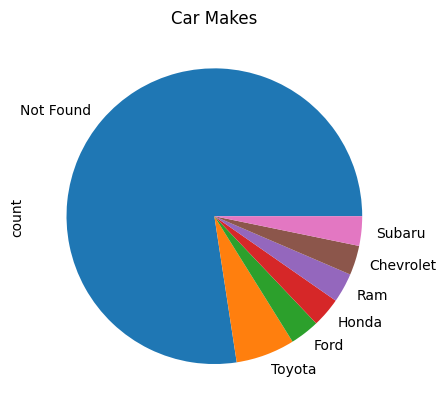

In [57]:
# car make 
df['car_make'].value_counts().plot(kind='pie')
plt.title('Car Makes')
plt.show()

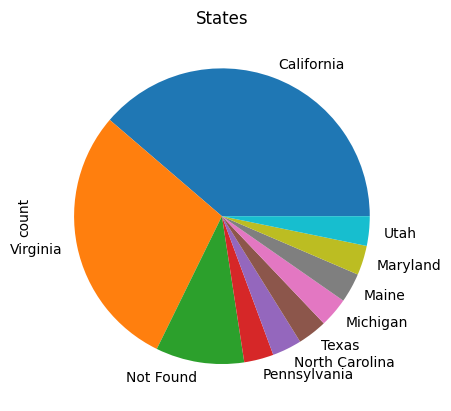

In [58]:
# car state 
df['state'].value_counts().plot(kind='pie')
plt.title('States')
plt.show()

In [59]:
plt.savefig('car_make_pie_chart.png')
plt.savefig('car_state_pie_chart.png')

<Figure size 640x480 with 0 Axes>

### upload pngs to s3

In [60]:
wr.s3.upload(local_file='car_make_pie_chart.png',path='s3://techcatalyst-raw/fabiola/ai/images_processed/car_make_pie_chart.png')
wr.s3.upload(local_file='car_state_pie_chart.png',path='s3://techcatalyst-raw/fabiola/ai/images_processed/car_state_pie_chart.png')